# ***Save/Load Model***

## Save

In [ ]:
# Saving the files for inference

output_model_file = '/content/drive/MyDrive/Colab Notebooks/toxicbert_FULLTRAIN.bin'
output_vocab_file = '/content/drive/MyDrive/Colab Notebooks/toxicbertvocab_FULLTRAIN.bin'

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved


## Load

In [ ]:
#model = DistilBERTClass()
model = torch.load('/content/drive/MyDrive/Colab Notebooks/toxicbert_FULLTRAIN.bin')
model.eval()

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

# ***Imports / PIPs***

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 66.1 MB/s 
     |████████████████████████████████| 182 kB 83.9 MB/s 


In [ ]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# ***Functions, Classes and Architecture***

## Model Class / Architecture
The ***architecture*** is rather simple, it consists of

*   Distilbert layer
*   Linear layer
*   Dropout layer
*   Classifier layer

for the ***Forward*** pass:

1.   `outputs_1` are the outputs of the Distilbert layer donated l1
2.   `hidden_state` are the tensors/predictions of the Distilbert
3.   `pooler` get only the CLS part of all predictions ( the CLS part is the prediction )
4.   `pooler` put preditctions in the network
5.   `pooler` apply non-linearity ( tanh ) to the prediction
6.   `pooler` apply regularization
7.   `output` get final classification


---
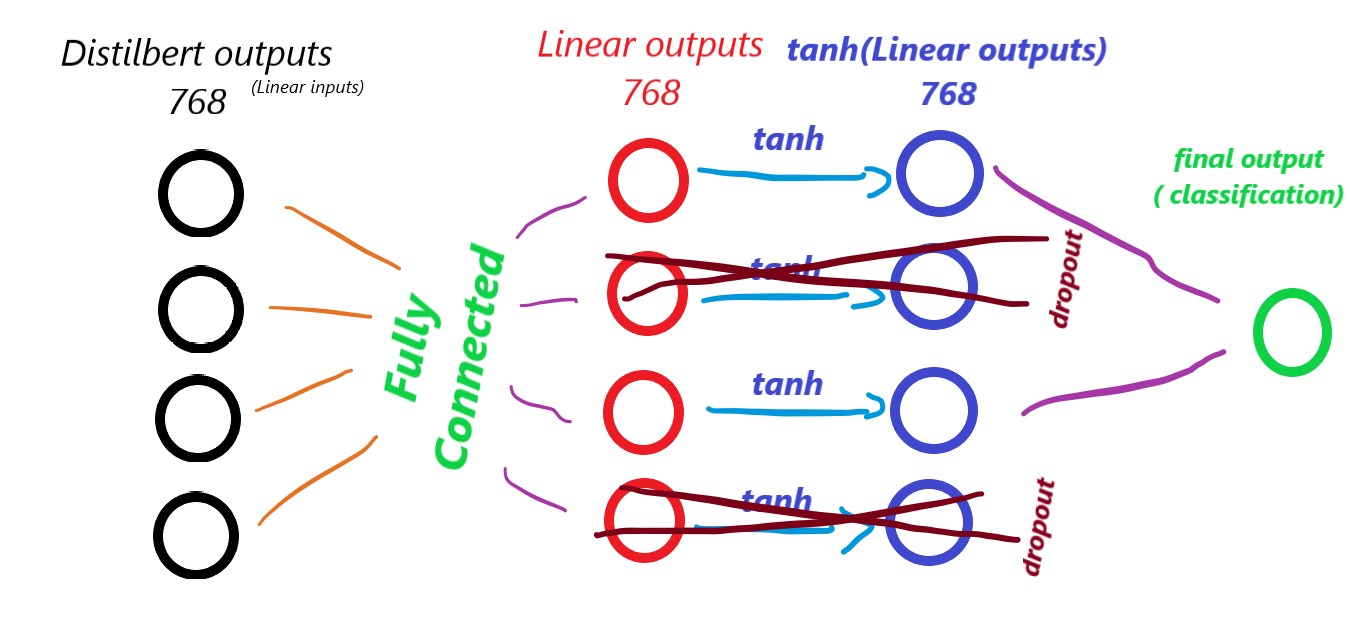


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module): # inherites from torch.nn.module
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask) # [number of examples, max number of tokens , number of hidden units]
        hidden_state = output_1[0] # predictions same as comment above (num ex , max len , num of hidden)
        pooler = hidden_state[:, 0] # all examples (sentences) CLS only ( first token which is prediction )
        pooler = self.pre_classifier(pooler) 
        pooler = torch.nn.Tanh()(pooler) 
        pooler = self.dropout(pooler) # apply regularization
        output = self.classifier(pooler) # linear classification
        return output


## Preprocessor / Dataset class
Takes a dataframe, Tokenizer and max_len variable
Functions in the class

1.   __len__ ( returns len of text )
2.   __getitem__ ( returns text tokenized and encoded )

returns preprocessed and tokenized dataset


In [ ]:
class Preprocessor(Dataset):
  def __init__(self,dataframe,tokenizer,max_len):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.text = dataframe.comment_text
    self.targets = dataframe.toxic

  def __len__(self):
    return len(self.text)

  def __getitem__(self,index):
    row_text = str(self.text[index])
    row_text = " ".join(row_text.split())

    inputs = self.tokenizer.encode_plus(
          row_text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
    
    ids = inputs['input_ids'] # numbers that represent tokens
    mask = inputs['attention_mask'] # attention masks 
    token_type_ids = inputs["token_type_ids"] # only useful in two sentences input ( or two types of inputs )


    return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(self.targets[index], dtype=torch.float)
    }

## Other Functions

### Loss function

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

### Train function


1.   `model.train()` tells the model that I'm trainning ( helps inform some layers )
2.   Iterate on trainning_loader(dataset) <br> `_` : Number of iterations, data : `data` batch of trainning_set (dataloader handles what i'm thinking lol) 


Start of the loop:

1.   Get (`ids`, `mask`, `token_type_ids`, `targets`) from the data and send them to device (GPU/CPU)
2.   Get outputs from model (apply forward pass on inputs)
3.   Reset gradients
4.   Calculate loss
5.   Calculate Gradient
6.   Step with optimizer ( Update parameters )

In [ ]:
def train(epoch):
    #1
    model.train()
    #2
    correct = 0
    for _,data in tqdm(enumerate(training_loader, 0)):
        #1
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        #2
        outputs = model(ids, mask, token_type_ids)

        #3
        optimizer.zero_grad()


        targets = targets.unsqueeze(1)
        #4
        loss = loss_fn(outputs, targets)

        if _%100==0: 
            print(f'Epoch: {epoch}, Loss:  {loss.item()}') ## print loss and epoch
        #5
        loss.backward()

        #6
        optimizer.step()

        correct += (outputs == targets).float().sum()
    accuracy = 100 * correct / len(training_set)
    print("Accuracy = {}".format(accuracy))

In [ ]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

### Validation Function

In [ ]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

### Hamming function
Simple hamming score/loss calculations, not worthy of any explination

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

# ***Download And Unzip Dataset***

In [ ]:
! kaggle datasets download akashsuper2000/toxic-comment-classification

 98% 20.0M/20.5M [00:02<00:00, 14.0MB/s]
100% 20.5M/20.5M [00:02<00:00, 10.1MB/s]


In [ ]:
!unzip '/content/toxic-comment-classification.zip'

Archive:  /content/toxic-comment-classification.zip
  inflating: test.csv                
  inflating: train.csv               
  inflating: validation.csv          


# ***Config / Settings***

In [ ]:
# Sections of config
# Defining some key variables that will be used later on in the training

MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4 
TEST_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
CLASSIFY_THRESHOLD = 0.5

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

# ***Prepare Inputs***

## Read Dataset

In [ ]:
train_data = pd.read_csv('/content/train.csv')
valid_data = pd.read_csv('/content/validation.csv')
test_data = pd.read_csv("/content/train.csv")
#data['labels'] = data.iloc[:, 1:].values.tolist()

## Initialize Tokenizer

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Split data & Prepare Dataset and Dataloader

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 1 # test data = 0.8 of whole data

train_data= data.sample(frac=train_size,random_state=200) # randomize whole data and return train_size frac of if
#test_data=data.drop(train_data.index).reset_index(drop=True) # test data = rest of whole data
#train_data = train_data.reset_index(drop=True)


#print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

TRAIN Dataset: (120000, 2)
VALID Dataset: (20000, 2)
TEST Dataset: (120000, 2)


In [ ]:
training_set = Preprocessor(train_data, tokenizer, MAX_LEN)
valid_set = Preprocessor(valid_data, tokenizer, MAX_LEN)
testing_set = Preprocessor(test_data, tokenizer, MAX_LEN)

In [ ]:
training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

# ***Creating Neural Network***


## Initialize Model

In [ ]:
model = DistilBERTClass()
model.to(device) # move the model to GPU

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Trainning

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1it [00:02,  2.60s/it]

Epoch: 0, Loss:  0.708614706993103


103it [00:08, 16.91it/s]

Epoch: 0, Loss:  0.07339447736740112


203it [00:14, 14.50it/s]

Epoch: 0, Loss:  0.16091719269752502


303it [00:20, 16.86it/s]

Epoch: 0, Loss:  0.040859948843717575


403it [00:26, 16.79it/s]

Epoch: 0, Loss:  0.3023402690887451


503it [00:32, 16.85it/s]

Epoch: 0, Loss:  0.027189062908291817


603it [00:38, 16.59it/s]

Epoch: 0, Loss:  0.041090235114097595


703it [00:44, 16.46it/s]

Epoch: 0, Loss:  0.07337278127670288


803it [00:50, 16.41it/s]

Epoch: 0, Loss:  0.023505521938204765


903it [00:56, 16.37it/s]

Epoch: 0, Loss:  0.05591490492224693


1003it [01:03, 16.40it/s]

Epoch: 0, Loss:  0.016668904572725296


1103it [01:09, 16.36it/s]

Epoch: 0, Loss:  0.07388168573379517


1203it [01:15, 16.44it/s]

Epoch: 0, Loss:  0.012515936978161335


1303it [01:21, 16.34it/s]

Epoch: 0, Loss:  0.009464391507208347


1403it [01:27, 16.39it/s]

Epoch: 0, Loss:  0.014741380698978901


1503it [01:33, 16.37it/s]

Epoch: 0, Loss:  0.536194920539856


1603it [01:39, 16.37it/s]

Epoch: 0, Loss:  0.032204680144786835


1703it [01:45, 16.10it/s]

Epoch: 0, Loss:  0.010381422936916351


1803it [01:51, 16.39it/s]

Epoch: 0, Loss:  0.020592032000422478


1903it [01:58, 16.05it/s]

Epoch: 0, Loss:  0.5996094346046448


2003it [02:04, 16.10it/s]

Epoch: 0, Loss:  0.19241949915885925


2103it [02:10, 16.06it/s]

Epoch: 0, Loss:  0.0217310581356287


2203it [02:16, 15.93it/s]

Epoch: 0, Loss:  0.03601565212011337


2303it [02:22, 15.98it/s]

Epoch: 0, Loss:  0.16235943138599396


2403it [02:29, 15.99it/s]

Epoch: 0, Loss:  0.4426800012588501


2503it [02:35, 15.87it/s]

Epoch: 0, Loss:  0.06354647129774094


2603it [02:41, 15.89it/s]

Epoch: 0, Loss:  0.1510033905506134


2703it [02:47, 15.65it/s]

Epoch: 0, Loss:  0.10928726941347122


2803it [02:54, 15.89it/s]

Epoch: 0, Loss:  0.6334293484687805


2903it [03:00, 15.79it/s]

Epoch: 0, Loss:  0.1509021520614624


3003it [03:06, 15.75it/s]

Epoch: 0, Loss:  0.02213088795542717


3103it [03:13, 15.82it/s]

Epoch: 0, Loss:  0.045220598578453064


3203it [03:19, 15.77it/s]

Epoch: 0, Loss:  0.07295630872249603


3303it [03:25, 15.77it/s]

Epoch: 0, Loss:  0.005456583108752966


3403it [03:32, 15.72it/s]

Epoch: 0, Loss:  0.004288967698812485


3503it [03:38, 15.62it/s]

Epoch: 0, Loss:  0.3796498477458954


3603it [03:45, 13.95it/s]

Epoch: 0, Loss:  0.013666044920682907


3703it [03:52, 15.64it/s]

Epoch: 0, Loss:  0.04205605387687683


3803it [03:58, 15.61it/s]

Epoch: 0, Loss:  0.014208720996975899


3903it [04:04, 15.56it/s]

Epoch: 0, Loss:  0.009362852200865746


4003it [04:11, 15.63it/s]

Epoch: 0, Loss:  0.006689554080367088


4103it [04:17, 15.55it/s]

Epoch: 0, Loss:  0.1804378479719162


4203it [04:24, 15.57it/s]

Epoch: 0, Loss:  0.0038499189540743828


4303it [04:30, 15.54it/s]

Epoch: 0, Loss:  0.18916383385658264


4403it [04:36, 15.49it/s]

Epoch: 0, Loss:  0.004812086466699839


4503it [04:43, 15.54it/s]

Epoch: 0, Loss:  0.04429049417376518


4603it [04:49, 15.53it/s]

Epoch: 0, Loss:  0.01208103634417057


4703it [04:56, 15.49it/s]

Epoch: 0, Loss:  0.027071280404925346


4803it [05:02, 15.53it/s]

Epoch: 0, Loss:  0.041788291186094284


4903it [05:09, 15.46it/s]

Epoch: 0, Loss:  1.1106666326522827


5003it [05:15, 15.54it/s]

Epoch: 0, Loss:  0.11481526494026184


5103it [05:22, 15.39it/s]

Epoch: 0, Loss:  0.6314707398414612


5203it [05:28, 15.48it/s]

Epoch: 0, Loss:  0.022616811096668243


5303it [05:35, 15.45it/s]

Epoch: 0, Loss:  0.15285946428775787


5403it [05:41, 15.45it/s]

Epoch: 0, Loss:  0.013452937826514244


5503it [05:47, 15.49it/s]

Epoch: 0, Loss:  0.056159988045692444


5603it [05:54, 15.47it/s]

Epoch: 0, Loss:  0.030019301921129227


5703it [06:00, 15.46it/s]

Epoch: 0, Loss:  1.1533219814300537


5803it [06:07, 15.48it/s]

Epoch: 0, Loss:  0.1311812549829483


5903it [06:13, 15.50it/s]

Epoch: 0, Loss:  0.4746828079223633


6003it [06:20, 15.59it/s]

Epoch: 0, Loss:  0.3336721658706665


6103it [06:26, 15.50it/s]

Epoch: 0, Loss:  0.06280534714460373


6203it [06:33, 15.51it/s]

Epoch: 0, Loss:  0.049468688666820526


6303it [06:39, 15.51it/s]

Epoch: 0, Loss:  0.06557530164718628


6403it [06:45, 15.42it/s]

Epoch: 0, Loss:  0.011947005987167358


6503it [06:52, 15.50it/s]

Epoch: 0, Loss:  0.30285903811454773


6603it [06:58, 15.50it/s]

Epoch: 0, Loss:  0.005772940348833799


6703it [07:05, 15.56it/s]

Epoch: 0, Loss:  0.0322994589805603


6803it [07:11, 15.53it/s]

Epoch: 0, Loss:  0.0288446843624115


6903it [07:18, 14.22it/s]

Epoch: 0, Loss:  0.0663883239030838


7003it [07:24, 15.53it/s]

Epoch: 0, Loss:  0.12200906127691269


7103it [07:31, 15.43it/s]

Epoch: 0, Loss:  0.058540526777505875


7203it [07:37, 15.60it/s]

Epoch: 0, Loss:  0.027297118678689003


7303it [07:44, 15.46it/s]

Epoch: 0, Loss:  0.018720202147960663


7403it [07:50, 15.43it/s]

Epoch: 0, Loss:  0.10704538971185684


7503it [07:57, 15.35it/s]

Epoch: 0, Loss:  0.49875375628471375


7603it [08:03, 15.44it/s]

Epoch: 0, Loss:  0.03954598680138588


7703it [08:10, 15.52it/s]

Epoch: 0, Loss:  0.09278944134712219


7803it [08:16, 15.45it/s]

Epoch: 0, Loss:  0.00907045602798462


7903it [08:22, 15.44it/s]

Epoch: 0, Loss:  0.016314668580889702


8003it [08:29, 15.45it/s]

Epoch: 0, Loss:  0.002736605703830719


8103it [08:35, 15.44it/s]

Epoch: 0, Loss:  0.0027354974299669266


8203it [08:42, 15.49it/s]

Epoch: 0, Loss:  0.21426738798618317


8303it [08:48, 15.54it/s]

Epoch: 0, Loss:  0.508994996547699


8403it [08:55, 15.51it/s]

Epoch: 0, Loss:  0.319464772939682


8503it [09:01, 15.49it/s]

Epoch: 0, Loss:  0.7573822140693665


8603it [09:08, 15.48it/s]

Epoch: 0, Loss:  0.08664575219154358


8703it [09:14, 15.42it/s]

Epoch: 0, Loss:  0.010803228244185448


8803it [09:21, 15.36it/s]

Epoch: 0, Loss:  0.0066681853495538235


8903it [09:27, 15.44it/s]

Epoch: 0, Loss:  0.00790733564645052


9003it [09:34, 15.27it/s]

Epoch: 0, Loss:  0.007762886583805084


9103it [09:40, 15.57it/s]

Epoch: 0, Loss:  0.0616583414375782


9203it [09:46, 15.48it/s]

Epoch: 0, Loss:  0.0048004500567913055


9303it [09:53, 15.45it/s]

Epoch: 0, Loss:  0.6282434463500977


9403it [09:59, 15.39it/s]

Epoch: 0, Loss:  0.01020783744752407


9503it [10:06, 15.51it/s]

Epoch: 0, Loss:  0.09357469528913498


9603it [10:12, 15.42it/s]

Epoch: 0, Loss:  0.006390045862644911


9703it [10:19, 15.47it/s]

Epoch: 0, Loss:  0.11364200711250305


9803it [10:25, 15.37it/s]

Epoch: 0, Loss:  0.0738382339477539


9903it [10:32, 15.53it/s]

Epoch: 0, Loss:  0.017218761146068573


10003it [10:38, 15.55it/s]

Epoch: 0, Loss:  0.09548863768577576


10103it [10:45, 15.34it/s]

Epoch: 0, Loss:  0.0016734667588025331


10203it [10:51, 15.51it/s]

Epoch: 0, Loss:  0.21739231050014496


10303it [10:58, 15.51it/s]

Epoch: 0, Loss:  0.07074854522943497


10403it [11:04, 15.47it/s]

Epoch: 0, Loss:  0.012886549346148968


10503it [11:11, 15.46it/s]

Epoch: 0, Loss:  0.201813206076622


10603it [11:17, 15.46it/s]

Epoch: 0, Loss:  0.28240588307380676


10703it [11:24, 15.55it/s]

Epoch: 0, Loss:  0.0036955021787434816


10803it [11:30, 15.51it/s]

Epoch: 0, Loss:  0.4503255784511566


10903it [11:37, 15.48it/s]

Epoch: 0, Loss:  0.004451892338693142


11003it [11:43, 15.48it/s]

Epoch: 0, Loss:  0.011372914537787437


11103it [11:49, 15.52it/s]

Epoch: 0, Loss:  0.010792911984026432


11203it [11:56, 15.53it/s]

Epoch: 0, Loss:  0.00419239979237318


11303it [12:02, 15.55it/s]

Epoch: 0, Loss:  0.010446596890687943


11403it [12:09, 15.47it/s]

Epoch: 0, Loss:  0.07886801660060883


11503it [12:15, 15.44it/s]

Epoch: 0, Loss:  0.11631593853235245


11603it [12:22, 15.48it/s]

Epoch: 0, Loss:  0.0016906514065340161


11703it [12:28, 15.51it/s]

Epoch: 0, Loss:  0.07592539489269257


11803it [12:35, 15.48it/s]

Epoch: 0, Loss:  0.1285884529352188


11903it [12:41, 15.52it/s]

Epoch: 0, Loss:  0.1543560028076172


12003it [12:47, 15.46it/s]

Epoch: 0, Loss:  0.0037860991433262825


12103it [12:54, 15.54it/s]

Epoch: 0, Loss:  0.011509270407259464


12203it [13:00, 15.52it/s]

Epoch: 0, Loss:  0.004030181560665369


12303it [13:07, 15.44it/s]

Epoch: 0, Loss:  0.11492467671632767


12403it [13:13, 15.45it/s]

Epoch: 0, Loss:  0.001291482476517558


12503it [13:20, 15.41it/s]

Epoch: 0, Loss:  0.02267683483660221


12603it [13:26, 15.47it/s]

Epoch: 0, Loss:  0.018390264362096786


12703it [13:33, 15.54it/s]

Epoch: 0, Loss:  0.10158215463161469


12803it [13:39, 15.50it/s]

Epoch: 0, Loss:  0.05039224773645401


12903it [13:46, 15.55it/s]

Epoch: 0, Loss:  0.30163130164146423


13003it [13:52, 15.54it/s]

Epoch: 0, Loss:  0.16191348433494568


13103it [13:58, 15.41it/s]

Epoch: 0, Loss:  0.040864430367946625


13203it [14:05, 15.41it/s]

Epoch: 0, Loss:  0.013302241452038288


13303it [14:11, 15.56it/s]

Epoch: 0, Loss:  0.024996668100357056


13403it [14:18, 14.27it/s]

Epoch: 0, Loss:  0.00160766183398664


13503it [14:24, 15.47it/s]

Epoch: 0, Loss:  0.040100328624248505


13603it [14:31, 15.49it/s]

Epoch: 0, Loss:  0.0883701890707016


13703it [14:37, 15.45it/s]

Epoch: 0, Loss:  0.2550816535949707


13803it [14:44, 15.46it/s]

Epoch: 0, Loss:  0.21412654221057892


13903it [14:50, 15.49it/s]

Epoch: 0, Loss:  0.07512272149324417


14003it [14:57, 15.47it/s]

Epoch: 0, Loss:  0.0354071743786335


14103it [15:03, 15.50it/s]

Epoch: 0, Loss:  0.20811878144741058


14203it [15:10, 15.50it/s]

Epoch: 0, Loss:  0.007762422785162926


14303it [15:16, 15.40it/s]

Epoch: 0, Loss:  0.005263573955744505


14403it [15:23, 15.51it/s]

Epoch: 0, Loss:  0.06997226923704147


14503it [15:29, 15.52it/s]

Epoch: 0, Loss:  0.0054558636620640755


14603it [15:35, 15.45it/s]

Epoch: 0, Loss:  0.08261009305715561


14703it [15:42, 15.48it/s]

Epoch: 0, Loss:  0.0028646872378885746


14803it [15:48, 15.46it/s]

Epoch: 0, Loss:  0.005731875076889992


14903it [15:55, 15.45it/s]

Epoch: 0, Loss:  0.04510121047496796


15003it [16:01, 15.53it/s]

Epoch: 0, Loss:  0.0868845283985138


15103it [16:08, 15.36it/s]

Epoch: 0, Loss:  0.03868105635046959


15203it [16:14, 15.37it/s]

Epoch: 0, Loss:  0.03922152519226074


15303it [16:21, 15.53it/s]

Epoch: 0, Loss:  0.019982503727078438


15403it [16:27, 15.50it/s]

Epoch: 0, Loss:  0.3304983973503113


15503it [16:34, 15.54it/s]

Epoch: 0, Loss:  0.02470134198665619


15603it [16:40, 15.52it/s]

Epoch: 0, Loss:  0.00994202122092247


15703it [16:47, 15.44it/s]

Epoch: 0, Loss:  0.08049634844064713


15803it [16:53, 15.50it/s]

Epoch: 0, Loss:  0.27071937918663025


15903it [16:59, 15.47it/s]

Epoch: 0, Loss:  0.036535125225782394


16003it [17:06, 15.55it/s]

Epoch: 0, Loss:  0.006443213205784559


16103it [17:12, 15.48it/s]

Epoch: 0, Loss:  0.06223078817129135


16203it [17:19, 15.45it/s]

Epoch: 0, Loss:  0.11103209108114243


16303it [17:25, 15.45it/s]

Epoch: 0, Loss:  0.0024676539469510317


16403it [17:32, 15.50it/s]

Epoch: 0, Loss:  0.5386412739753723


16503it [17:38, 15.54it/s]

Epoch: 0, Loss:  0.01822592318058014


16603it [17:45, 15.56it/s]

Epoch: 0, Loss:  0.0053110262379050255


16703it [17:51, 15.47it/s]

Epoch: 0, Loss:  0.20840349793434143


16803it [17:58, 15.44it/s]

Epoch: 0, Loss:  0.002088907640427351


16903it [18:04, 15.54it/s]

Epoch: 0, Loss:  0.08157505095005035


17003it [18:11, 15.49it/s]

Epoch: 0, Loss:  0.8818397521972656


17103it [18:17, 15.45it/s]

Epoch: 0, Loss:  0.07723528891801834


17203it [18:23, 15.48it/s]

Epoch: 0, Loss:  0.045956261456012726


17303it [18:30, 15.50it/s]

Epoch: 0, Loss:  0.05252334848046303


17403it [18:36, 15.50it/s]

Epoch: 0, Loss:  0.034340064972639084


17503it [18:43, 15.49it/s]

Epoch: 0, Loss:  0.0017303172498941422


17603it [18:49, 15.49it/s]

Epoch: 0, Loss:  0.049179237335920334


17703it [18:56, 15.53it/s]

Epoch: 0, Loss:  0.002950793132185936


17803it [19:02, 15.44it/s]

Epoch: 0, Loss:  0.00917917862534523


17903it [19:09, 15.59it/s]

Epoch: 0, Loss:  0.05093604326248169


18003it [19:15, 15.54it/s]

Epoch: 0, Loss:  0.008935405872762203


18103it [19:21, 15.45it/s]

Epoch: 0, Loss:  0.07044124603271484


18203it [19:28, 15.50it/s]

Epoch: 0, Loss:  0.03163931146264076


18303it [19:34, 15.49it/s]

Epoch: 0, Loss:  0.05508448928594589


18403it [19:41, 15.50it/s]

Epoch: 0, Loss:  0.007887441664934158


18503it [19:47, 15.48it/s]

Epoch: 0, Loss:  0.002128077670931816


18603it [19:54, 15.51it/s]

Epoch: 0, Loss:  0.09530875831842422


18703it [20:00, 15.47it/s]

Epoch: 0, Loss:  0.0011463086120784283


18803it [20:07, 15.51it/s]

Epoch: 0, Loss:  0.09870588034391403


18903it [20:13, 15.48it/s]

Epoch: 0, Loss:  0.03473127633333206


19003it [20:19, 15.45it/s]

Epoch: 0, Loss:  0.008093958720564842


19103it [20:26, 15.43it/s]

Epoch: 0, Loss:  0.0016876859590411186


19203it [20:32, 15.52it/s]

Epoch: 0, Loss:  0.9682860374450684


19303it [20:39, 15.41it/s]

Epoch: 0, Loss:  0.05061732232570648


19403it [20:45, 15.52it/s]

Epoch: 0, Loss:  0.04300067201256752


19503it [20:52, 15.51it/s]

Epoch: 0, Loss:  0.0010796247515827417


19603it [20:58, 15.48it/s]

Epoch: 0, Loss:  0.07836966216564178


19703it [21:05, 15.50it/s]

Epoch: 0, Loss:  0.0008893297053873539


19803it [21:11, 15.42it/s]

Epoch: 0, Loss:  0.0006268130382522941


19903it [21:18, 15.25it/s]

Epoch: 0, Loss:  0.11924413591623306


20003it [21:24, 15.45it/s]

Epoch: 0, Loss:  0.22824107110500336


20103it [21:31, 15.45it/s]

Epoch: 0, Loss:  0.39562317728996277


20203it [21:37, 15.41it/s]

Epoch: 0, Loss:  0.8427313566207886


20303it [21:44, 15.41it/s]

Epoch: 0, Loss:  0.008060457184910774


20403it [21:50, 15.41it/s]

Epoch: 0, Loss:  0.010488919913768768


20503it [21:57, 15.50it/s]

Epoch: 0, Loss:  0.00273174699395895


20603it [22:03, 15.53it/s]

Epoch: 0, Loss:  0.03781227022409439


20703it [22:09, 15.45it/s]

Epoch: 0, Loss:  0.005722980480641127


20803it [22:16, 15.49it/s]

Epoch: 0, Loss:  0.00276675121858716


20903it [22:22, 15.46it/s]

Epoch: 0, Loss:  0.13207989931106567


21003it [22:29, 15.45it/s]

Epoch: 0, Loss:  0.003470777999609709


21103it [22:35, 15.44it/s]

Epoch: 0, Loss:  0.002170313149690628


21203it [22:42, 15.42it/s]

Epoch: 0, Loss:  0.022554121911525726


21303it [22:48, 15.47it/s]

Epoch: 0, Loss:  0.003968678880482912


21403it [22:55, 15.43it/s]

Epoch: 0, Loss:  0.0054091354832053185


21503it [23:01, 15.42it/s]

Epoch: 0, Loss:  0.0008958267280831933


21603it [23:08, 15.40it/s]

Epoch: 0, Loss:  0.004503530450165272


21703it [23:14, 15.45it/s]

Epoch: 0, Loss:  0.053187910467386246


21803it [23:21, 15.54it/s]

Epoch: 0, Loss:  0.027637656778097153


21903it [23:27, 15.43it/s]

Epoch: 0, Loss:  0.001124777365475893


22003it [23:33, 15.49it/s]

Epoch: 0, Loss:  0.0018556469585746527


22103it [23:40, 15.46it/s]

Epoch: 0, Loss:  0.2678171992301941


22203it [23:46, 15.44it/s]

Epoch: 0, Loss:  0.016248434782028198


22303it [23:53, 15.51it/s]

Epoch: 0, Loss:  0.08912559598684311


22403it [23:59, 15.54it/s]

Epoch: 0, Loss:  0.09513703733682632


22503it [24:06, 15.51it/s]

Epoch: 0, Loss:  0.0029626647010445595


22603it [24:12, 15.49it/s]

Epoch: 0, Loss:  0.07315786927938461


22703it [24:19, 15.50it/s]

Epoch: 0, Loss:  0.11784356087446213


22803it [24:25, 15.43it/s]

Epoch: 0, Loss:  0.328009694814682


22903it [24:32, 15.48it/s]

Epoch: 0, Loss:  0.004294414073228836


23003it [24:38, 15.49it/s]

Epoch: 0, Loss:  0.09460911899805069


23103it [24:45, 15.23it/s]

Epoch: 0, Loss:  1.5749919414520264


23203it [24:51, 15.52it/s]

Epoch: 0, Loss:  0.06541396677494049


23303it [24:58, 15.47it/s]

Epoch: 0, Loss:  0.007015744224190712


23403it [25:04, 15.43it/s]

Epoch: 0, Loss:  0.3284763693809509


23503it [25:10, 15.53it/s]

Epoch: 0, Loss:  0.1517927199602127


23603it [25:17, 15.56it/s]

Epoch: 0, Loss:  0.05782003328204155


23703it [25:23, 15.43it/s]

Epoch: 0, Loss:  0.0015960452146828175


23803it [25:30, 15.50it/s]

Epoch: 0, Loss:  0.011988464742898941


23903it [25:36, 15.48it/s]

Epoch: 0, Loss:  0.005150891840457916


24003it [25:43, 15.54it/s]

Epoch: 0, Loss:  0.3353395462036133


24103it [25:49, 15.48it/s]

Epoch: 0, Loss:  0.05674183368682861


24203it [25:56, 15.51it/s]

Epoch: 0, Loss:  0.15708374977111816


24303it [26:02, 15.50it/s]

Epoch: 0, Loss:  0.0015347402077168226


24403it [26:09, 15.50it/s]

Epoch: 0, Loss:  0.31357091665267944


24503it [26:15, 15.53it/s]

Epoch: 0, Loss:  0.19237537682056427


24603it [26:21, 15.39it/s]

Epoch: 0, Loss:  0.48199233412742615


24703it [26:28, 15.47it/s]

Epoch: 0, Loss:  0.032821301370859146


24803it [26:34, 15.50it/s]

Epoch: 0, Loss:  0.019117414951324463


24903it [26:41, 15.52it/s]

Epoch: 0, Loss:  0.1207270696759224


25003it [26:47, 15.55it/s]

Epoch: 0, Loss:  0.0212759580463171


25103it [26:54, 15.50it/s]

Epoch: 0, Loss:  0.0013955978211015463


25203it [27:00, 15.48it/s]

Epoch: 0, Loss:  0.004010701086372137


25303it [27:07, 15.53it/s]

Epoch: 0, Loss:  0.023263443261384964


25403it [27:13, 15.47it/s]

Epoch: 0, Loss:  0.008082589134573936


25503it [27:20, 15.43it/s]

Epoch: 0, Loss:  0.002560880733653903


25603it [27:26, 15.49it/s]

Epoch: 0, Loss:  0.4858330190181732


25703it [27:32, 15.51it/s]

Epoch: 0, Loss:  0.27100735902786255


25803it [27:39, 15.52it/s]

Epoch: 0, Loss:  0.2882705628871918


25903it [27:45, 15.55it/s]

Epoch: 0, Loss:  0.011865576729178429


26003it [27:52, 15.55it/s]

Epoch: 0, Loss:  0.001122513902373612


26103it [27:58, 15.45it/s]

Epoch: 0, Loss:  0.029100798070430756


26203it [28:05, 15.53it/s]

Epoch: 0, Loss:  0.0028748740442097187


26303it [28:11, 14.86it/s]

Epoch: 0, Loss:  0.4098547697067261


26403it [28:18, 15.48it/s]

Epoch: 0, Loss:  0.395565003156662


26503it [28:24, 15.51it/s]

Epoch: 0, Loss:  0.0011309059336781502


26603it [28:31, 15.46it/s]

Epoch: 0, Loss:  0.00663432152941823


26703it [28:37, 15.55it/s]

Epoch: 0, Loss:  0.005971688777208328


26803it [28:44, 15.52it/s]

Epoch: 0, Loss:  0.0825049877166748


26903it [28:50, 15.47it/s]

Epoch: 0, Loss:  0.5804309248924255


27003it [28:57, 15.53it/s]

Epoch: 0, Loss:  0.1911056488752365


27103it [29:03, 15.48it/s]

Epoch: 0, Loss:  0.01623210497200489


27203it [29:10, 15.40it/s]

Epoch: 0, Loss:  0.5317262411117554


27303it [29:16, 15.46it/s]

Epoch: 0, Loss:  0.11356920003890991


27403it [29:22, 15.50it/s]

Epoch: 0, Loss:  0.002667684806510806


27503it [29:29, 15.45it/s]

Epoch: 0, Loss:  0.030819324776530266


27603it [29:35, 15.46it/s]

Epoch: 0, Loss:  0.0030652196146547794


27703it [29:42, 15.47it/s]

Epoch: 0, Loss:  0.15729892253875732


27803it [29:48, 15.44it/s]

Epoch: 0, Loss:  0.15199580788612366


27903it [29:55, 15.56it/s]

Epoch: 0, Loss:  0.10637983679771423


28003it [30:01, 15.50it/s]

Epoch: 0, Loss:  0.5807937979698181


28103it [30:08, 15.47it/s]

Epoch: 0, Loss:  0.01146002672612667


28203it [30:14, 15.59it/s]

Epoch: 0, Loss:  0.002548706717789173


28303it [30:20, 15.47it/s]

Epoch: 0, Loss:  1.3299076557159424


28403it [30:27, 15.49it/s]

Epoch: 0, Loss:  0.06360668689012527


28503it [30:33, 15.51it/s]

Epoch: 0, Loss:  0.02044423669576645


28603it [30:40, 15.44it/s]

Epoch: 0, Loss:  0.10563045740127563


28703it [30:46, 15.44it/s]

Epoch: 0, Loss:  0.03424910083413124


28803it [30:53, 15.51it/s]

Epoch: 0, Loss:  0.049321502447128296


28903it [30:59, 15.42it/s]

Epoch: 0, Loss:  0.0038830614648759365


29003it [31:06, 15.45it/s]

Epoch: 0, Loss:  0.014520937576889992


29103it [31:12, 15.41it/s]

Epoch: 0, Loss:  0.15383830666542053


29203it [31:19, 15.44it/s]

Epoch: 0, Loss:  0.02576345019042492


29303it [31:25, 15.44it/s]

Epoch: 0, Loss:  0.09198613464832306


29403it [31:32, 15.41it/s]

Epoch: 0, Loss:  0.0016457901801913977


29503it [31:38, 15.44it/s]

Epoch: 0, Loss:  0.011856546625494957


29603it [31:45, 15.44it/s]

Epoch: 0, Loss:  0.06406067311763763


29703it [31:51, 15.53it/s]

Epoch: 0, Loss:  0.001279820455238223


29803it [31:57, 15.43it/s]

Epoch: 0, Loss:  0.0019463786156848073


29903it [32:04, 15.51it/s]

Epoch: 0, Loss:  0.11775919795036316


30000it [32:10, 15.54it/s]

Accuracy = 0.0


# ***Set Testing***

In [ ]:
testing_set = Preprocessor(csv_filtered, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
nulls = []
for x in range(len(testing_set)):
  try:
      testing_set.__getitem__(x)
  except KeyError:
      nulls.append(x)
      continue

In [ ]:
len(nulls)

218

In [ ]:
nulls

[90,
 116,
 168,
 187,
 241,
 243,
 275,
 375,
 422,
 548,
 612,
 618,
 640,
 731,
 799,
 865,
 915,
 934,
 979,
 990,
 994,
 1133,
 1163,
 1258,
 1268,
 1395,
 1402,
 1404,
 1419,
 1502,
 1507,
 1569,
 1587,
 1629,
 1679,
 1687,
 1712,
 1727,
 1835,
 1851,
 1882,
 1950,
 2087,
 2114,
 2153,
 2338,
 2340,
 2476,
 2506,
 2584,
 2627,
 2630,
 2649,
 2735,
 2742,
 2764,
 2773,
 2779,
 2829,
 2857,
 2893,
 2907,
 2920,
 2945,
 3093,
 3132,
 3149,
 3166,
 3210,
 3241,
 3246,
 3248,
 3293,
 3301,
 3337,
 3388,
 3423,
 3491,
 3512,
 3514,
 3592,
 3608,
 3668,
 3687,
 3724,
 3757,
 3773,
 3778,
 3797,
 3870,
 3871,
 3892,
 3893,
 3904,
 3994,
 4007,
 4042,
 4051,
 4091,
 4094,
 4096,
 4103,
 4114,
 4123,
 4126,
 4218,
 4294,
 4295,
 4469,
 4508,
 4534,
 4541,
 4561,
 4693,
 4713,
 4754,
 4803,
 4865,
 4910,
 4953,
 5000,
 5015,
 5047,
 5104,
 5119,
 5159,
 5183,
 5284,
 5365,
 5406,
 5490,
 5565,
 5577,
 5596,
 5617,
 5627,
 5682,
 5802,
 5848,
 5935,
 6061,
 6145,
 6405,
 6481,
 6512,
 6563,


In [ ]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >= CLASSIFY_THRESHOLD

In [ ]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

In [ ]:
from sklearn.metrics import f1_score
f1_score(targets, final_outputs)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(targets, final_outputs)